Assuming we have compiled and installed mpml by following the README file we are ready to perform experiments

In [1]:
from random import sample
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from scipy import sparse
from typing import Tuple, List
import argparse
import gril.gril as gril
import torch
import torch.nn as nn
from scipy.spatial import Delaunay

Let's import some helper functions already defined in ``utils.py``

In [2]:
from utils import *

In [3]:
num_circles = 2
num_disks = 0
experiment_name = f'circle_{num_circles}_disk_{num_disks}'
data = create_circles_and_disks(num_circles, num_disks, False)


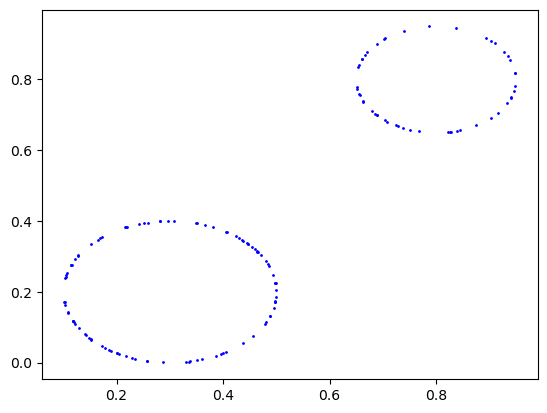

In [4]:
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=1, c='b')
plt.show()

In [5]:
class MultiPersLandscapeValLayer(nn.Module):
    def __init__(self, res, hom_rank, step, l):
        super().__init__()
        self.res = res
        self.step = step
        self.l = l
        self.sample_pts = self.sample_grid()
        self.hom_rank = hom_rank
        self.filt_layer = get_filtration
        self.mpl = gril.MultiPers(hom_rank=hom_rank, l=l, step=2, res=res, ranks=list(range(1, 6)))
        self.mpl.set_max_jobs(40)

    def sample_grid(self):
        pts = []
        num_division = int(1.0 / self.res)
        for j in range(0, num_division, self.step):
            for i in range(0, num_division, self.step):
                pts.append((i, j))
        return pts

    def forward(self, x, edges, tri, tri_converted):
        num_vertices = x.shape[0]
        f, e = self.filt_layer(x, edges, tri, tri_converted)
        simplices = get_simplices(num_vertices, e, tri)
        pers_inp = [(f, simplices)]
        bars = self.mpl.compute_landscape(self.sample_pts, pers_inp)
        return bars

In [6]:
edges, triangles, tri_converted = delaunay_complex(data)
x = torch.tensor(data, dtype=torch.float)
num_vertices = x.shape[0]

layer1_0 = MultiPersLandscapeValLayer(res=0.01, hom_rank=0, step=2, l=2)
# layer1_1 = MultiPersLandscapeValLayer(res=0.01, hom_rank=1, step=2, l=2)

out1_0 = layer1_0(x, edges, triangles, tri_converted)
lmbda1_0 = out1_0[0]
layer1_0.mpl.set_hom_rank(1)
out1_1 = layer1_0(x, edges, triangles, tri_converted)
lmbda1_1 = out1_1[0]

Took 19839 ms
Took 1842 ms


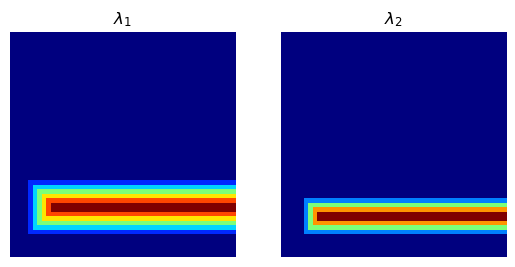

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
h1 = lmbda1_1.numpy().reshape((50, 50, 5))
h1_1 = h1[:, :, 0].reshape((50, 50))
h1_2 = h1[:, :, 1].reshape((50, 50))
ax1.imshow(h1_1, cmap='jet', origin='lower')
ax1.set_title('$\lambda_1$')
ax1.set_axis_off()
ax2.imshow(h1_2, cmap='jet', origin='lower')
ax2.set_title('$\lambda_2$')
ax2.set_axis_off()
plt.show()
